In [44]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from collections import Counter

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

## Load the data set - 40 subjects, each with 10 pictures

In [45]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content')

In [46]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [47]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [48]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Check a specific subject's image set

In [90]:
# Accessing the data for a specific set of images
set_number = 's2' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

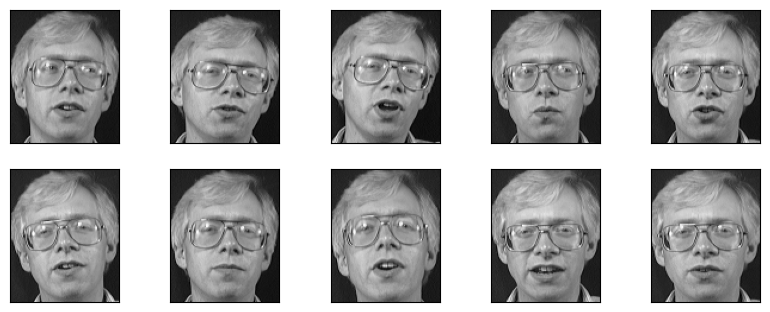

In [91]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

### Image Stats

In [51]:
# Initialize a dictionary to hold average pixel intensities for each class
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for class {class_name}: {avg_intensity}")

Average pixel intensity for class s24: 103.14790372670807
Average pixel intensity for class s12: 121.021525621118
Average pixel intensity for class s16: 121.01252911490683
Average pixel intensity for class s5: 130.87773680124224
Average pixel intensity for class s38: 108.30481366459628
Average pixel intensity for class s30: 99.23293866459626
Average pixel intensity for class s18: 135.5274650621118
Average pixel intensity for class s34: 97.42004076086957
Average pixel intensity for class s32: 125.42356366459629
Average pixel intensity for class s39: 83.92661102484473
Average pixel intensity for class s27: 113.87108889751553
Average pixel intensity for class s36: 111.48193905279501
Average pixel intensity for class s20: 101.92547554347826
Average pixel intensity for class s31: 106.60304736024844
Average pixel intensity for class s25: 124.24754464285714
Average pixel intensity for class s13: 129.1649844720497
Average pixel intensity for class s22: 85.16769215838508
Average pixel intensity

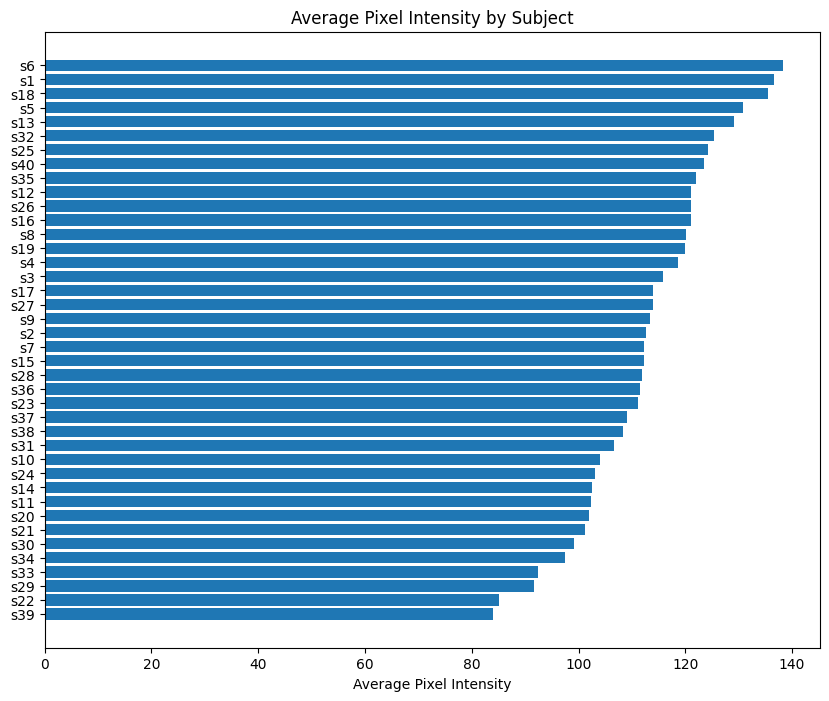

In [52]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

## Random Forest

Inspired by https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [53]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=1, stratify=y_data)

In [54]:
# Assign Random Forest model 
RFmodel = RandomForestClassifier()

# Fit the Random Forest Classifier on the training data
RFmodel.fit(X_train, y_train)

RandomForestClassifier()

In [55]:
# Make predictions on the test set
RF_y_pred = RFmodel.predict(X_test)

In [56]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 96.25%


In [57]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(RFconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [58]:
# Print the classification report for Random Forest model
RFclassification_report = classification_report(y_test, RF_y_pred)
print(f"Random Forest Classification Report:")
print(RFclassification_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

          s1       1.00      0.67      0.80         3
         s10       1.00      1.00      1.00         3
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       0.75      1.00      0.86         3
         s15       1.00      1.00      1.00         3
         s16       0.75      1.00      0.86         3
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         3
         s19       1.00      1.00      1.00         2
          s2       0.75      1.00      0.86         3
         s20       1.00      1.00      1.00         3
         s21       1.00      1.00      1.00         3
         s22       1.00      0.50      0.67         2
         s23       1.00      1.00      1.00         3
         s24       1.00      1.00      1.00 

## Exploration of Results for Random Forest

In [59]:
# Finding Misclassified images in Random Forest

# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})

RFmisclassified_df

,True Label,Predicted Label
0,s22,s14
1,s1,s16
2,s40,s5
3,s32,s2


#!! Needs to be addressed:

In [60]:
# Inspecting the distribution of training and test sets (used in both Random Forest and Logistic Regression)

# Count occurrences of each label in the training set
train_label_counts = Counter(y_train)

# Count occurrences of each label in the test set
test_label_counts = Counter(y_test)

# Display the counts
print("Training label counts:", train_label_counts)
print("Test label counts:", test_label_counts)

Training label counts: Counter({'s39': 8, 's19': 8, 's35': 8, 's6': 8, 's4': 8, 's12': 8, 's38': 8, 's25': 8, 's37': 8, 's13': 8, 's22': 8, 's11': 8, 's27': 8, 's29': 8, 's34': 8, 's33': 8, 's5': 8, 's36': 8, 's3': 8, 's9': 8, 's23': 7, 's10': 7, 's2': 7, 's28': 7, 's18': 7, 's21': 7, 's8': 7, 's20': 7, 's17': 7, 's31': 7, 's14': 7, 's15': 7, 's16': 7, 's24': 7, 's7': 7, 's26': 7, 's40': 7, 's1': 7, 's32': 7, 's30': 7})
Test label counts: Counter({'s7': 3, 's28': 3, 's21': 3, 's32': 3, 's16': 3, 's1': 3, 's15': 3, 's24': 3, 's31': 3, 's40': 3, 's26': 3, 's14': 3, 's17': 3, 's10': 3, 's8': 3, 's18': 3, 's30': 3, 's23': 3, 's2': 3, 's20': 3, 's4': 2, 's34': 2, 's35': 2, 's9': 2, 's36': 2, 's6': 2, 's3': 2, 's12': 2, 's38': 2, 's13': 2, 's27': 2, 's33': 2, 's5': 2, 's39': 2, 's37': 2, 's25': 2, 's22': 2, 's29': 2, 's19': 2, 's11': 2})


## Visualizations for Random Forest

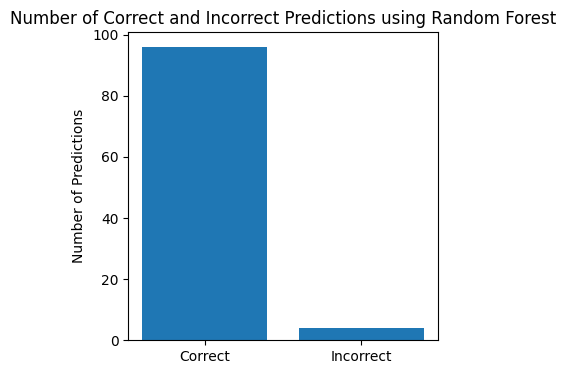

In [61]:
# Calculate number of correct and incorrect predictions using Random Forest
correct_predictions = sum(y_test_array == RF_y_pred_array)
incorrect_predictions = sum(y_test_array != RF_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Random Forest")
plt.show()

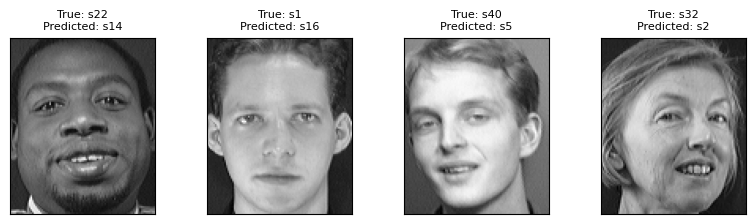

In [62]:
# Display misclassified images along with text indicating True and Predicted subjects for Random Forest

# Iterate through misclassified images and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(RFmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = RF_y_pred_array[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)

plt.tight_layout()
plt.show()

##Logistic Regression

In [63]:
# Scale the data for Logistic Regression
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Assign Logistic Regression model
LRmodel = LogisticRegression(max_iter=1000)

# Fit Logistic Regression model using training data
LRmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [65]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test)

In [66]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 98.33%


In [67]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [68]:
# Print the classification report for Logistic Regression model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      0.67      0.80         3
         s10       1.00      1.00      1.00         3
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         3
         s15       1.00      1.00      1.00         3
         s16       1.00      1.00      1.00         3
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         3
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      1.00      1.00         3
         s21       1.00      1.00      1.00         3
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         3
         s24       0.75      1.00     

## Exploration of Results for Logistic Regression

In [69]:
# Finding Misclassified images in Logistic Regression

# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})

LRmisclassified_df


,True Label,Predicted Label
0,s1,s24
1,s40,s5


## Visualizations for Logistic Regression

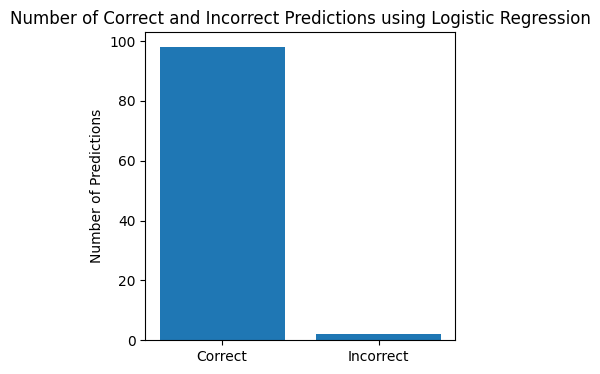

In [70]:
# Calculate number of correct and incorrect predictions using Logistic Regression
correct_predictions = sum(y_test_array == LR_y_pred_array)
incorrect_predictions = sum(y_test_array != LR_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Logistic Regression")
plt.show()

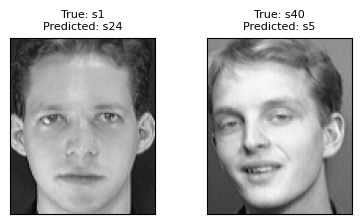

In [71]:
# Display misclassified images along with text indicating True and Predicted subjects for Logistic Regression

# Iterate through misclassified indices and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(LRmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = LR_y_pred[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)

plt.tight_layout()
plt.show()


## CNN - work in progress
Inspired by https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [138]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets, use random_state 1
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.2, random_state=1, stratify=y_data)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (320, 112, 92), y_train_original = (320,)
X_test_original = (80, 112, 92), y_test_original = (80,)


In [139]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (320, 112, 92, 1)
X_train_original contains 320 images
X_test_original contains 80 images


In [140]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [141]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [142]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [143]:
# Creating a sequential model named and adding layers to it
network = models.Sequential()
network.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
network.add(layers.Dense(40, activation='softmax'))

In [144]:
# Compile the model
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [145]:
# Fit the model
history = network.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = network.evaluate(X_test_original, y_test_encoded)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
8/8 [==============================] - 3s 257ms/step - loss: 6.9549 - accuracy: 0.0078 - val_loss: 4.1979 - val_accuracy: 0.0469
Epoch 2/20
8/8 [==============================] - 2s 273ms/step - loss: 3.7933 - accuracy: 0.0352 - val_loss: 3.6939 - val_accuracy: 0.0312
Epoch 3/20
8/8 [==============================] - 2s 300ms/step - loss: 3.6660 - accuracy: 0.0625 - val_loss: 3.6762 - val_accuracy: 0.0312
Epoch 4/20
8/8 [==============================] - 2s 239ms/step - loss: 3.6136 - accuracy: 0.0391 - val_loss: 3.6752 - val_accuracy: 0.0312
Epoch 5/20
8/8 [==============================] - 2s 239ms/step - loss: 3.4946 - accuracy: 0.0859 - val_loss: 3.5463 - val_accuracy: 0.0781
Epoch 6/20
8/8 [==============================] - 2s 237ms/step - loss: 3.3037 - accuracy: 0.1172 - val_loss: 3.3641 - val_accuracy: 0.0938
Epoch 7/20
8/8 [==============================] - 2s 239ms/step - loss: 3.0129 - accuracy: 0.1758 - val_loss: 3.1422 - val_accuracy: 0.1719
Epoch 8/20
8/8 [====

In [146]:
print("Training Loss:", history.history['loss'])

Training Loss: [6.954879283905029, 3.7932956218719482, 3.6659786701202393, 3.613603115081787, 3.4946494102478027, 3.3036818504333496, 3.012871503829956, 2.6734352111816406, 2.213078022003174, 1.775930404663086, 1.2878934144973755, 0.9347732067108154, 0.6058475375175476, 0.3725304901599884, 0.21277177333831787, 0.14917607605457306, 0.08538344502449036, 0.05631697177886963, 0.03374307602643967, 0.023008057847619057]


## Exploration of Results for CNN

## Visualizations for CNN

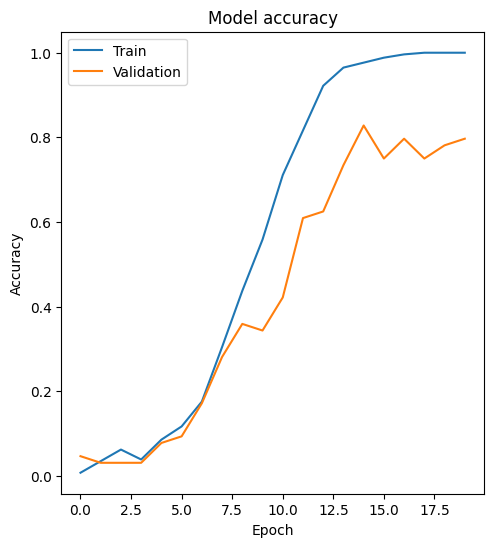

In [147]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



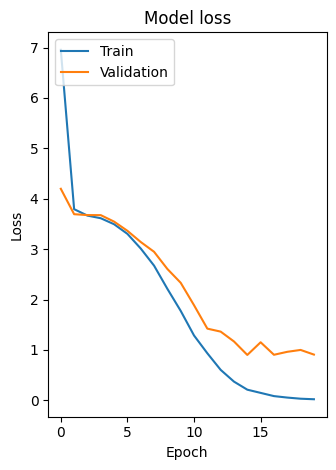

In [148]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()